In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from scipy.stats import ttest_ind
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import pickle  

# Load Data Sets

In [2]:
train_df = pd.read_csv('train.csv').drop(labels='Id', axis=1)
test_df = pd.read_csv('test.csv').drop(labels='Id', axis=1)

In [3]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# TRAIN

# <<-- Convert 'YearBuilt', 'YearRemodAdd' and 'GarageYrBlt' to 'HouseAge', 'RennovationYears' and 'GarageAge' respectively -->>

train_df['HouseAge'] = 2020 - train_df['YearBuilt']
train_df['RennovationYears'] = 2020 - train_df['YearRemodAdd']
train_df['GarageAge'] = 2020 - train_df['GarageYrBlt']

# Drop 'YearBuilt', 'YearRemodAdd' and 'GarageYrBlt'

train_df.drop(labels=['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], axis=1, inplace=True)

In [5]:
# TEST

# <<-- Convert 'YearBuilt', 'YearRemodAdd' and 'GarageYrBlt' to 'HouseAge', 'RennovationYears' and 'GarageAge' respectively -->>

test_df['HouseAge'] = 2020 - test_df['YearBuilt']
test_df['RennovationYears'] = 2020 - test_df['YearRemodAdd']
test_df['GarageAge'] = 2020 - test_df['GarageYrBlt']

# Drop 'YearBuilt', 'YearRemodAdd' and 'GarageYrBlt'

test_df.drop(labels=['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], axis=1, inplace=True)

In [6]:
continuous_features = [
    'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'HouseAge', 
    'RennovationYears', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
    'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
    'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'Bedroom', 'Kitchen',
    'TotRmsAbvGrd', 'Fireplaces', 'GarageAge', 'GarageCars', 'GarageArea',
    'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
    'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'
]

In [7]:
discrete_features = [
    'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 
    'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 
    'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
    'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 
    'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
    'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType',
    'SaleCondition'
]

# Exploratory Data Analysis (EDA)

In [8]:
train_df['GarageCars'].unique()

array([2, 3, 1, 0, 4], dtype=int64)

In [9]:
train_df.shape

(1460, 80)

In [10]:
column_names = train_df.columns
types = [train_df[column].dtype for column in column_names]
total_count = [train_df[column].count() for column in column_names]
distincts = [len(train_df[column].unique()) for column in column_names]
null_count = [train_df[column].isnull().sum() for column in column_names]
null_percentage = [round((n_c/1460)*100, 2) for n_c in null_count]
skewness = [round(train_df[column].skew(), 3) if column in continuous_features else np.nan for column in column_names]
correlation_SalesPrice = [round(train_df[column].corr(train_df['SalePrice']), 3) if column in continuous_features else np.nan for column in column_names]
feature_type = ['continuous' if column in continuous_features else 'categorical' for column in column_names]

data = zip(types, total_count, distincts, null_count, null_percentage, skewness, correlation_SalesPrice, feature_type)

temp_df = pd.DataFrame(data=data, columns=['types', 'total_count', 'distincts', 'null_count', 
                                           'null_percentage', 'skewness', 'correlation_SalesPrice', 'feature_type'], index=column_names)
pd.set_option('display.max_rows', 100)

In [11]:
temp_df.shape

(80, 8)

In [12]:
temp_df.sort_values(by='correlation_SalesPrice', ascending=False)

,types,total_count,distincts,null_count,null_percentage,skewness,correlation_SalesPrice,feature_type
SalePrice,int64,1460,663,0,0.00,1.883,1.000,continuous
OverallQual,int64,1460,10,0,0.00,0.217,0.791,continuous
GrLivArea,int64,1460,861,0,0.00,1.367,0.709,continuous
GarageCars,int64,1460,5,0,0.00,-0.343,0.640,continuous
GarageArea,int64,1460,441,0,0.00,0.180,0.623,continuous
TotalBsmtSF,int64,1460,721,0,0.00,1.524,0.614,continuous
1stFlrSF,int64,1460,753,0,0.00,1.377,0.606,continuous
FullBath,int64,1460,4,0,0.00,0.037,0.561,continuous
TotRmsAbvGrd,int64,1460,12,0,0.00,0.676,0.534,continuous
MasVnrArea,float64,1452,328,8,0.55,2.669,0.477,continuous


In [13]:
temp_df.loc[['MoSold', 'YrSold'], ['null_percentage', 'skewness', 'correlation_SalesPrice']]

,null_percentage,skewness,correlation_SalesPrice
MoSold,0.0,0.212,0.046
YrSold,0.0,0.096,-0.029


In [14]:
# TRAIN

# <<-- Drop 'MoSold' and 'YrSold' as they are having very less correlation with Sale Price -->>

temp_df.drop(labels=['MoSold', 'YrSold'], axis=0,  inplace=True)
train_df.drop(labels=['MoSold', 'YrSold'], axis=1,  inplace=True)

In [15]:
# TEST

test_df.drop(labels=['MoSold', 'YrSold'], axis=1,  inplace=True)

In [16]:
# <<--- Features having null values more than 47%.  --->>

temp_df[temp_df['null_percentage'] > 47]

,types,total_count,distincts,null_count,null_percentage,skewness,correlation_SalesPrice,feature_type
Alley,object,91,3,1369,93.77,NaN,NaN,categorical
FireplaceQu,object,770,6,690,47.26,NaN,NaN,categorical
PoolQC,object,7,4,1453,99.52,NaN,NaN,categorical
Fence,object,281,5,1179,80.75,NaN,NaN,categorical
MiscFeature,object,54,5,1406,96.30,NaN,NaN,categorical


In [17]:
# TRAIN

# Drop the features having null values more than 47%

null_columns = temp_df[temp_df['null_percentage'] > 47].index

train_df.drop(labels=null_columns, axis=1, inplace=True)

temp_df.drop(labels=null_columns, axis=0, inplace=True)

In [18]:
# TEST

test_df.drop(labels=null_columns, axis=1, inplace=True)

In [19]:
temp_df.sort_values(by='correlation_SalesPrice', ascending=False)

,types,total_count,distincts,null_count,null_percentage,skewness,correlation_SalesPrice,feature_type
SalePrice,int64,1460,663,0,0.00,1.883,1.000,continuous
OverallQual,int64,1460,10,0,0.00,0.217,0.791,continuous
GrLivArea,int64,1460,861,0,0.00,1.367,0.709,continuous
GarageCars,int64,1460,5,0,0.00,-0.343,0.640,continuous
GarageArea,int64,1460,441,0,0.00,0.180,0.623,continuous
TotalBsmtSF,int64,1460,721,0,0.00,1.524,0.614,continuous
1stFlrSF,int64,1460,753,0,0.00,1.377,0.606,continuous
FullBath,int64,1460,4,0,0.00,0.037,0.561,continuous
TotRmsAbvGrd,int64,1460,12,0,0.00,0.676,0.534,continuous
MasVnrArea,float64,1452,328,8,0.55,2.669,0.477,continuous


In [20]:
# <<<-- Remove the features that have very less correlation -->>> 

In [21]:
mask = ((temp_df['correlation_SalesPrice'] > 0.30) | (temp_df['correlation_SalesPrice'] < -0.30))
columns = temp_df[~mask]
mask2 = (columns['feature_type'] == 'continuous')
columns = columns[mask2]
columns_to_drop = columns.index
columns_to_drop

Index(['LotArea', 'OverallCond', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF',
       'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [22]:
# TRAIN

train_df.drop(labels=columns_to_drop, axis=1, inplace=True)
temp_df.drop(labels=columns_to_drop, axis=0, inplace=True)

In [23]:
# TEST

test_df.drop(labels=columns_to_drop, axis=1, inplace=True)

In [24]:
# <<--- Higly skewed features --->>

mask = ((temp_df['skewness'] > 1) | (temp_df['skewness'] < -1))
skewed_df = temp_df[mask]

skewed_df.sort_values(by='correlation_SalesPrice', ascending=False)

,types,total_count,distincts,null_count,null_percentage,skewness,correlation_SalesPrice,feature_type
SalePrice,int64,1460,663,0,0.00,1.883,1.000,continuous
GrLivArea,int64,1460,861,0,0.00,1.367,0.709,continuous
TotalBsmtSF,int64,1460,721,0,0.00,1.524,0.614,continuous
1stFlrSF,int64,1460,753,0,0.00,1.377,0.606,continuous
MasVnrArea,float64,1452,328,8,0.55,2.669,0.477,continuous
BsmtFinSF1,int64,1460,637,0,0.00,1.686,0.386,continuous
LotFrontage,float64,1201,111,259,17.74,2.164,0.352,continuous
WoodDeckSF,int64,1460,274,0,0.00,1.541,0.324,continuous
OpenPorchSF,int64,1460,202,0,0.00,2.364,0.316,continuous


In [25]:
# <-- Fixing 'GrLivArea' -->

Skewness: 1.3665603560164552


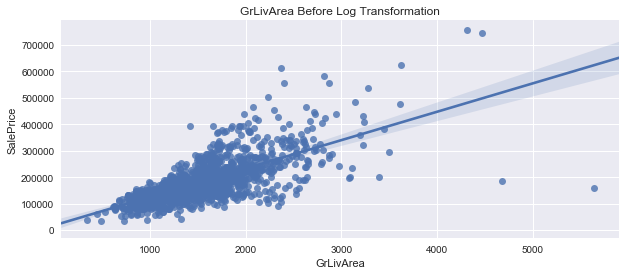

In [26]:
plt.rcParams['figure.figsize'] = (10, 4)

sns.regplot(x='GrLivArea', y='SalePrice', data=train_df)
plt.title('GrLivArea Before Log Transformation')

print(f'Skewness: {train_df["GrLivArea"].skew()}')

Skewness: -0.006995182187690808


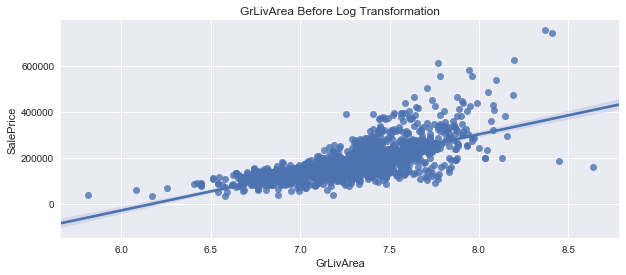

In [27]:
sns.regplot(x=np.log(train_df['GrLivArea']), y=train_df['SalePrice'])
plt.title('GrLivArea Before Log Transformation')

print(f'Skewness: {np.log(train_df["GrLivArea"]).skew()}')

In [28]:
# TRAIN

# Change 'GrLivArea' to log scale as it reduces the skewness

train_df['GrLivArea'] = np.log(train_df['GrLivArea'])

In [29]:
# TEST

test_df['GrLivArea'] = np.log(test_df['GrLivArea'])

In [30]:
# <-- Fix 'TotalBsmtSF' -->

Skewness: 1.5242545490627664


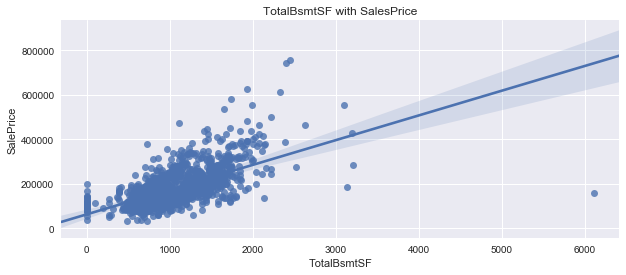

In [31]:
sns.regplot(x='TotalBsmtSF', y='SalePrice', data=train_df)
plt.title('TotalBsmtSF with SalesPrice')

print(f'Skewness: {train_df["TotalBsmtSF"].skew()}')

Text(0.5, 1.0, 'TotalBsmtSF with SalesPrice')

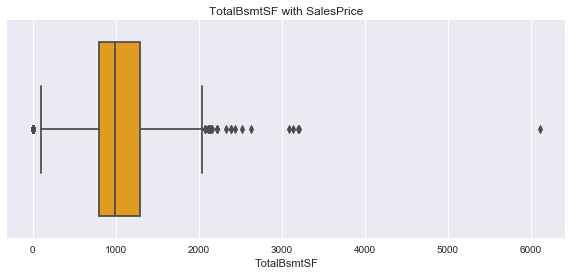

In [32]:
sns.boxplot(x=train_df['TotalBsmtSF'], color='orange')
plt.title('TotalBsmtSF with SalesPrice')

In [33]:
mask = (train_df['TotalBsmtSF'] < 6000)
train_df = train_df[mask]

Skewness: 0.5736369416201317


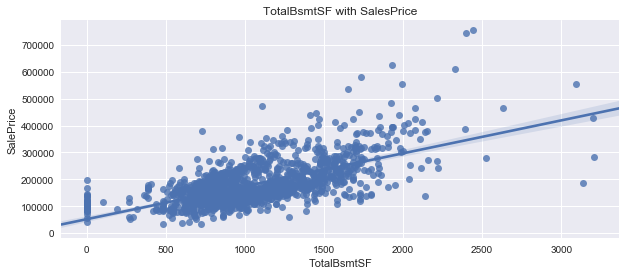

In [34]:
sns.regplot(x='TotalBsmtSF', y='SalePrice', data=train_df)
plt.title('TotalBsmtSF with SalesPrice')

print(f'Skewness: {train_df["TotalBsmtSF"].skew()}')

In [35]:
# <-- Fix '1stFlrSF' -->

Skewness: 0.9524102073822629


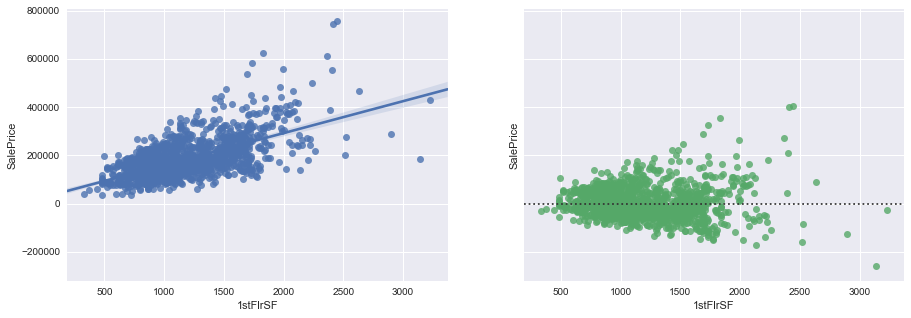

In [36]:
fig1, ax1 =plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey='all')

sns.regplot(x='1stFlrSF', y='SalePrice', data=train_df, ax=ax1[0])
sns.residplot(x='1stFlrSF', y='SalePrice', data=train_df, ax=ax1[1])

print(f'Skewness: {train_df["1stFlrSF"].skew()}')

Skewness: 0.024190871030479195


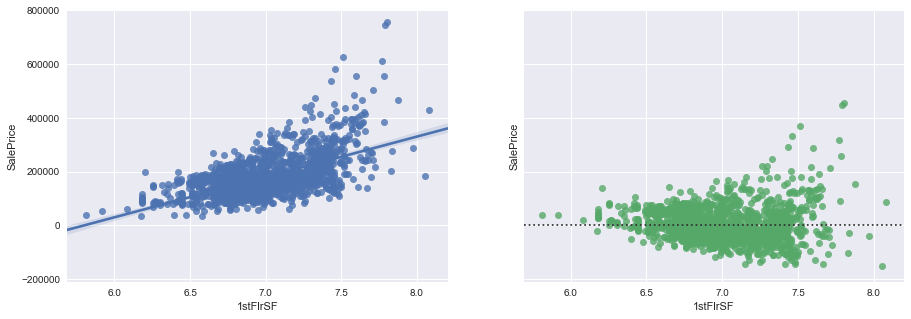

In [37]:
fig1, ax1 =plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey='all')

sns.regplot(x=np.log(train_df['1stFlrSF']), y=train_df['SalePrice'], ax=ax1[0])
sns.residplot(x=np.log(train_df['1stFlrSF']), y=train_df['SalePrice'], ax=ax1[1])

print(f'Skewness: {np.log(train_df["1stFlrSF"]).skew()}')

In [38]:
# TRAIN

# Change '1stFlrSF' to log scale

train_df['1stFlrSF'] = np.log(train_df['1stFlrSF'])

In [39]:
# TEST

test_df['1stFlrSF'] = np.log(test_df['1stFlrSF'])

In [40]:
# <-- Fix 'MasVnrArea' -->

Skewness: 2.6778329809927097


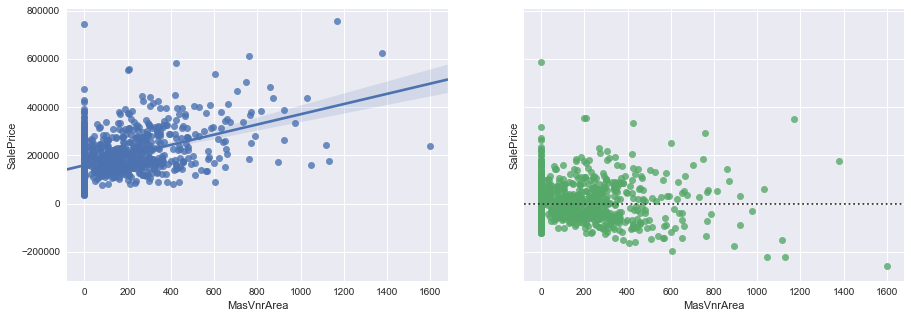

In [41]:
fig1, ax1 =plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey='all')

sns.regplot(x='MasVnrArea', y='SalePrice', data=train_df, ax=ax1[0])
sns.residplot(x='MasVnrArea', y='SalePrice', data=train_df, ax=ax1[1])

print(f'Skewness: {train_df["MasVnrArea"].skew()}')

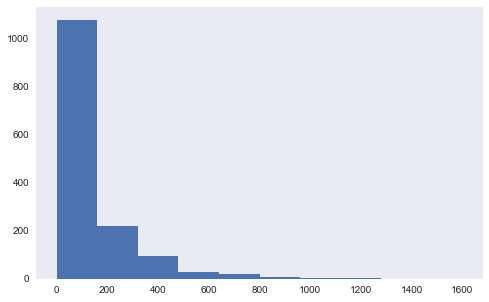

In [42]:
train_df['MasVnrArea'].hist(grid=False, figsize=(8, 5))

In [43]:
# <-- Fix 'BsmtFinSF1' -->

Skewness: 0.7929692261037329


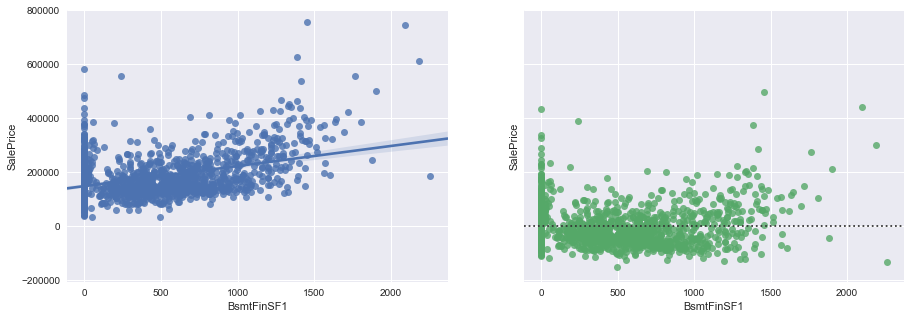

In [44]:
fig1, ax1 =plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey='all')

sns.regplot(x='BsmtFinSF1', y='SalePrice', data=train_df, ax=ax1[0])
sns.residplot(x='BsmtFinSF1', y='SalePrice', data=train_df, ax=ax1[1])

print(f'Skewness: {train_df["BsmtFinSF1"].skew()}')

In [45]:
# <-- Fix 'LotFrontage' -->

Skewness: 1.5387807137369176


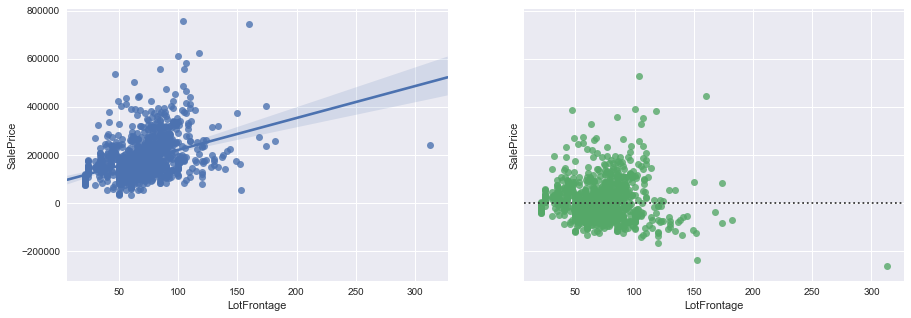

In [46]:
fig1, ax1 =plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey='all')

sns.regplot(x='LotFrontage', y='SalePrice', data=train_df, ax=ax1[0])
sns.residplot(x='LotFrontage', y='SalePrice', data=train_df, ax=ax1[1])

print(f'Skewness: {train_df["LotFrontage"].skew()}')

In [47]:
# Dropping the outliar of 'LotFrontage' that if greater than 300

mask =  (train_df['LotFrontage'] > 300)
train_df = train_df[~mask]

Skewness: 0.7016172504183159


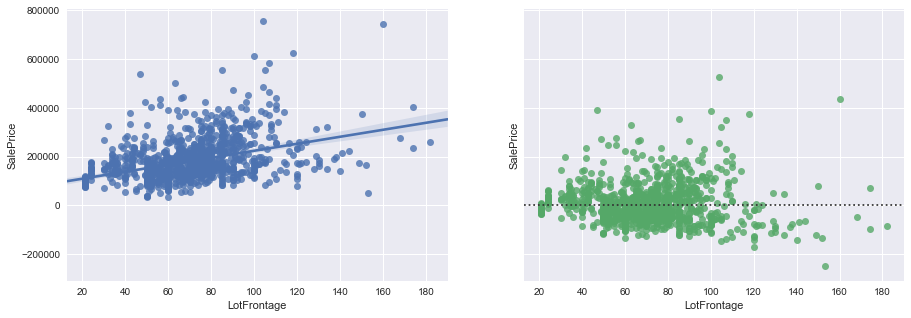

In [48]:
fig1, ax1 =plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey='all')

sns.regplot(x='LotFrontage', y='SalePrice', data=train_df, ax=ax1[0])
sns.residplot(x='LotFrontage', y='SalePrice', data=train_df, ax=ax1[1])

print(f'Skewness: {train_df["LotFrontage"].skew()}')

Skewness: 1.5427780250021375


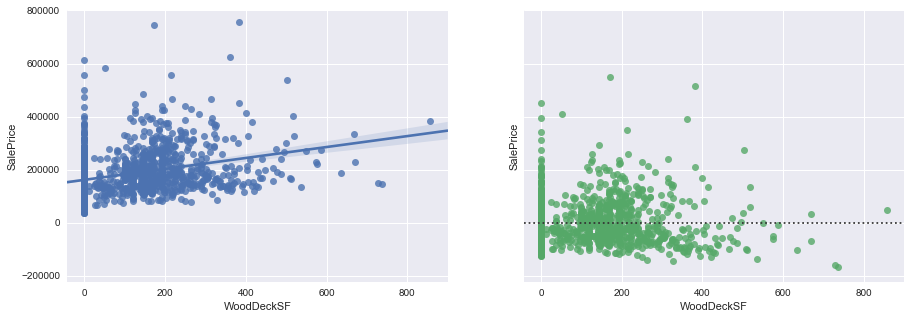

In [49]:
# <-- Fix 'WoodDeckSF' -->

fig1, ax1 =plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey='all')

sns.regplot(x='WoodDeckSF', y='SalePrice', data=train_df, ax=ax1[0])
sns.residplot(x='WoodDeckSF', y='SalePrice', data=train_df, ax=ax1[1])

print(f'Skewness: {train_df["WoodDeckSF"].skew()}')

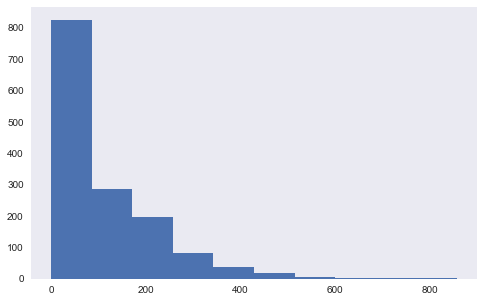

In [50]:
train_df['WoodDeckSF'].hist(figsize=(8, 5), grid=False)

Skewness: 2.368786251366203


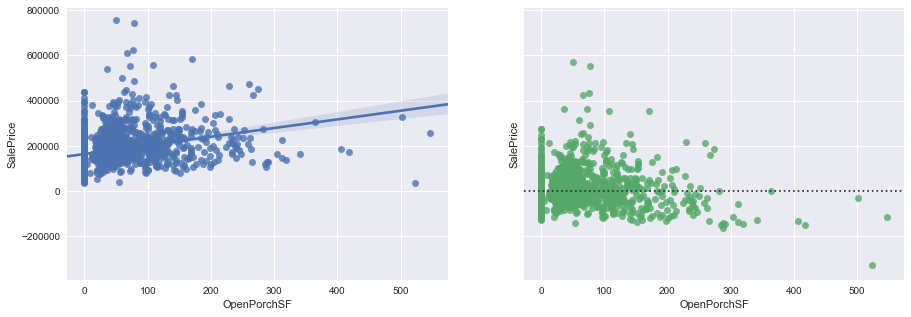

In [51]:
# <-- Fix 'OpenPorchSF' -->

fig1, ax1 =plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey='all')

sns.regplot(x='OpenPorchSF', y='SalePrice', data=train_df, ax=ax1[0])
sns.residplot(x='OpenPorchSF', y='SalePrice', data=train_df, ax=ax1[1])

print(f'Skewness: {train_df["OpenPorchSF"].skew()}')

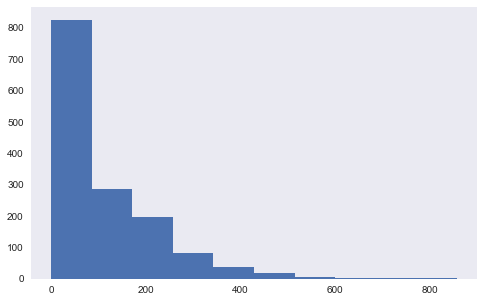

In [52]:
train_df['WoodDeckSF'].hist(figsize=(8, 5), grid=False)

In [53]:
column_names = train_df.columns
types = [train_df[column].dtype for column in column_names]
total_count = [train_df[column].count() for column in column_names]
distincts = [len(train_df[column].unique()) for column in column_names]
null_count = [train_df[column].isnull().sum() for column in column_names]
null_percentage = [round((n_c/1460)*100, 2) for n_c in null_count]
skewness = [round(train_df[column].skew(), 3) if column in continuous_features else np.nan for column in column_names]
correlation_SalesPrice = [round(train_df[column].corr(train_df['SalePrice']), 3) if column in continuous_features else np.nan for column in column_names]
feature_type = ['continuous' if column in continuous_features else 'categorical' for column in column_names]

data = zip(types, total_count, distincts, null_count, null_percentage, skewness, correlation_SalesPrice, feature_type)

temp_df = pd.DataFrame(data=data, columns=['types', 'total_count', 'distincts', 'null_count', 
                                           'null_percentage', 'skewness', 'correlation_SalesPrice', 'feature_type'], index=column_names)
pd.set_option('display.max_rows', 100)

In [54]:
temp_df.shape

(60, 8)

In [55]:
train_df['GarageCars'].unique()

array([2, 3, 1, 0, 4], dtype=int64)

In [56]:
# <<<-- Correlation Matrix -->>>

In [57]:
corr_matrix = train_df.corr()

(22.0, 0.0)

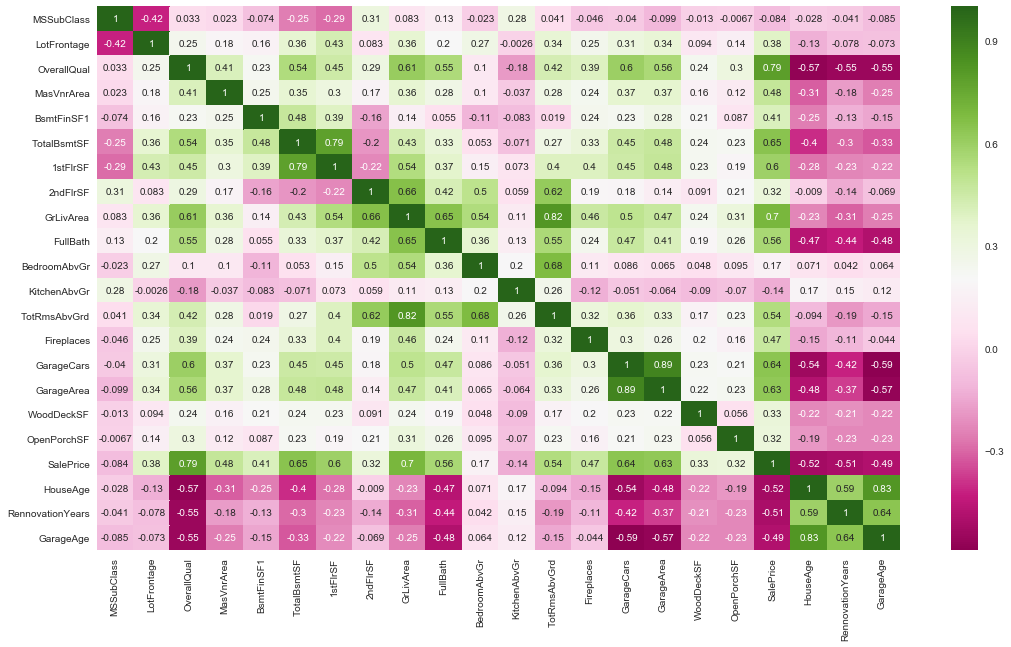

In [58]:
plt.rcParams['figure.figsize'] = (18, 10)

# Heatmap of corelation matrix
ax = sns.heatmap(data=corr_matrix, annot=True, cmap="PiYG")

# below two lines are just to put the heat map or matrix properly 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [59]:
train_df['GarageCars'].corr(train_df['GarageArea'])

0.8875302490004396

In [60]:
# TRAIN

# Drop 'GarageArea' and 'GarageAge'

temp_df.drop(labels='GarageArea', axis=0, inplace=True)
train_df.drop(labels='GarageArea', axis=1, inplace=True)

temp_df.drop(labels='GarageAge', axis=0, inplace=True)
train_df.drop(labels='GarageAge', axis=1, inplace=True)

In [61]:
# TEST

# Drop 'GarageArea' and 'GarageAge'

test_df.drop(labels='GarageArea', axis=1, inplace=True)
test_df.drop(labels='GarageAge', axis=1, inplace=True)

In [62]:
temp_df.sort_values(by='correlation_SalesPrice', ascending=False)

,types,total_count,distincts,null_count,null_percentage,skewness,correlation_SalesPrice,feature_type
SalePrice,int64,1458,663,0,0.00,1.884,1.000,continuous
OverallQual,int64,1458,10,0,0.00,0.210,0.794,continuous
GrLivArea,float64,1458,859,0,0.00,-0.046,0.700,continuous
TotalBsmtSF,int64,1458,720,0,0.00,0.573,0.647,continuous
GarageCars,int64,1458,5,0,0.00,-0.341,0.640,continuous
1stFlrSF,float64,1458,752,0,0.00,0.023,0.596,continuous
FullBath,int64,1458,4,0,0.00,0.039,0.561,continuous
TotRmsAbvGrd,int64,1458,12,0,0.00,0.666,0.536,continuous
MasVnrArea,float64,1450,327,8,0.55,2.677,0.481,continuous
Fireplaces,int64,1458,4,0,0.00,0.632,0.470,continuous


In [63]:
# <<-- Fix all Basements null values -->>

In [64]:
pd.set_option('display.max_rows', 50)

basment_features = ['TotalBsmtSF', 'BsmtFinSF1', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
t_d = train_df[basment_features]
mask = (t_d['TotalBsmtSF'] == 0)
t_d[mask]

,TotalBsmtSF,BsmtFinSF1,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
17,0,0,NaN,NaN,NaN,NaN,NaN
39,0,0,NaN,NaN,NaN,NaN,NaN
90,0,0,NaN,NaN,NaN,NaN,NaN
102,0,0,NaN,NaN,NaN,NaN,NaN
156,0,0,NaN,NaN,NaN,NaN,NaN
182,0,0,NaN,NaN,NaN,NaN,NaN
259,0,0,NaN,NaN,NaN,NaN,NaN
342,0,0,NaN,NaN,NaN,NaN,NaN
362,0,0,NaN,NaN,NaN,NaN,NaN
371,0,0,NaN,NaN,NaN,NaN,NaN


In [65]:
# TRAIN

# Replace all np.nan values in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'] with 'NA'

columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

for column in columns:
    train_df[column].replace({np.nan:'NA'}, inplace=True)

In [66]:
# TEST

# Replace all np.nan values in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'] with 'NA'

columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

for column in columns:
    test_df[column].replace({np.nan:'NA'}, inplace=True)

In [67]:
# <<-- Fix null values of Garages -->>

In [68]:
columns = ['GarageCars', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
mask = (train_df['GarageCars'] == 0)
train_df[mask][columns]

,GarageCars,GarageType,GarageFinish,GarageQual,GarageCond
39,0,NaN,NaN,NaN,NaN
48,0,NaN,NaN,NaN,NaN
78,0,NaN,NaN,NaN,NaN
88,0,NaN,NaN,NaN,NaN
89,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...
1349,0,NaN,NaN,NaN,NaN
1407,0,NaN,NaN,NaN,NaN
1449,0,NaN,NaN,NaN,NaN
1450,0,NaN,NaN,NaN,NaN


In [69]:
# TRAIN

# Replace all np.nan values in ['GarageCars', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'] with 'NA'

columns = ['GarageCars', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']

for column in columns:
    train_df[column].replace({np.nan:'NA'}, inplace=True)

In [70]:
# TEST

# Replace all np.nan values in ['GarageCars', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'] with 'NA'

columns = ['GarageCars', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']

for column in columns:
    test_df[column].replace({np.nan:'NA'}, inplace=True)

In [71]:
# TRAIN

# Fill Null values of 'LotFrontage'

train_df[train_df['LotFrontage'] == np.nan]


for index, i in zip(train_df['LotFrontage'].index, train_df['LotFrontage']):
    if str(i) == 'nan':
        
        row = train_df.loc[index, :]
        
        MSSubClass = row['MSSubClass']
        GarageCars = row['GarageCars']
        MSZoning = row['MSZoning']
        
        mask = ((train_df['MSSubClass'] == MSSubClass) & (train_df['GarageCars'] == GarageCars) &
               (train_df['MSZoning'] == MSZoning))
        
        value = train_df[mask]['LotFrontage'].median()
        
        if str(value) == 'nan':
            mask = mask = ((train_df['MSSubClass'] == MSSubClass) & (train_df['MSZoning'] == MSZoning))
            value = train_df[mask]['LotFrontage'].median()
        
        train_df.loc[index, 'LotFrontage'] = value

In [72]:
# TEST

# Fill Null values of 'LotFrontage'

test_df[test_df['LotFrontage'] == np.nan]


for index, i in zip(test_df['LotFrontage'].index, test_df['LotFrontage']):
    if str(i) == 'nan':
        
        row = test_df.loc[index, :]
        
        MSSubClass = row['MSSubClass']
        GarageCars = row['GarageCars']
        MSZoning = row['MSZoning']
        
        mask = ((test_df['MSSubClass'] == MSSubClass) & (test_df['GarageCars'] == GarageCars) &
               (test_df['MSZoning'] == MSZoning))
        
        value = test_df[mask]['LotFrontage'].median()
        
        if str(value) == 'nan':
            mask = mask = ((test_df['MSSubClass'] == MSSubClass) & (test_df['MSZoning'] == MSZoning))
            value = test_df[mask]['LotFrontage'].median()
        
        test_df.loc[index, 'LotFrontage'] = value

In [73]:
# Fill null values of 'MasVnrArea' and 'MasVnrType'

In [74]:
# TRAIN

train_df['MasVnrArea'].replace({np.nan: 0}, inplace=True)
train_df['MasVnrType'].replace({np.nan:'NA', 'None':'NA'}, inplace=True)

In [75]:
# TEST

test_df['MasVnrArea'].replace({np.nan: 0}, inplace=True)
test_df['MasVnrType'].replace({np.nan:'NA', 'None':'NA'}, inplace=True)

In [76]:
column_names = train_df.columns
types = [train_df[column].dtype for column in column_names]
total_count = [train_df[column].count() for column in column_names]
distincts = [len(train_df[column].unique()) for column in column_names]
null_count = [train_df[column].isnull().sum() for column in column_names]
null_percentage = [round((n_c/1460)*100, 2) for n_c in null_count]
skewness = [round(train_df[column].skew(), 3) if column in continuous_features else np.nan for column in column_names]
correlation_SalesPrice = [round(train_df[column].corr(train_df['SalePrice']), 3) if column in continuous_features else np.nan for column in column_names]
feature_type = ['continuous' if column in continuous_features else 'categorical' for column in column_names]

data = zip(types, total_count, distincts, null_count, null_percentage, skewness, correlation_SalesPrice, feature_type)

temp_df = pd.DataFrame(data=data, columns=['types', 'total_count', 'distincts', 'null_count', 
                                           'null_percentage', 'skewness', 'correlation_SalesPrice', 'feature_type'], index=column_names)
pd.set_option('display.max_rows', 100)

In [77]:
temp_df.sort_values(by='correlation_SalesPrice', ascending=False)

,types,total_count,distincts,null_count,null_percentage,skewness,correlation_SalesPrice,feature_type
SalePrice,int64,1458,663,0,0.00,1.884,1.000,continuous
OverallQual,int64,1458,10,0,0.00,0.210,0.794,continuous
GrLivArea,float64,1458,859,0,0.00,-0.046,0.700,continuous
TotalBsmtSF,int64,1458,720,0,0.00,0.573,0.647,continuous
GarageCars,int64,1458,5,0,0.00,-0.341,0.640,continuous
1stFlrSF,float64,1458,752,0,0.00,0.023,0.596,continuous
FullBath,int64,1458,4,0,0.00,0.039,0.561,continuous
TotRmsAbvGrd,int64,1458,12,0,0.00,0.666,0.536,continuous
MasVnrArea,float64,1458,326,0,0.00,2.685,0.476,continuous
Fireplaces,int64,1458,4,0,0.00,0.632,0.470,continuous


In [78]:
# Temporary save data to visualize it in the tableau

train_df.to_excel(excel_writer='train.xlsx', sheet_name='Sheet1')

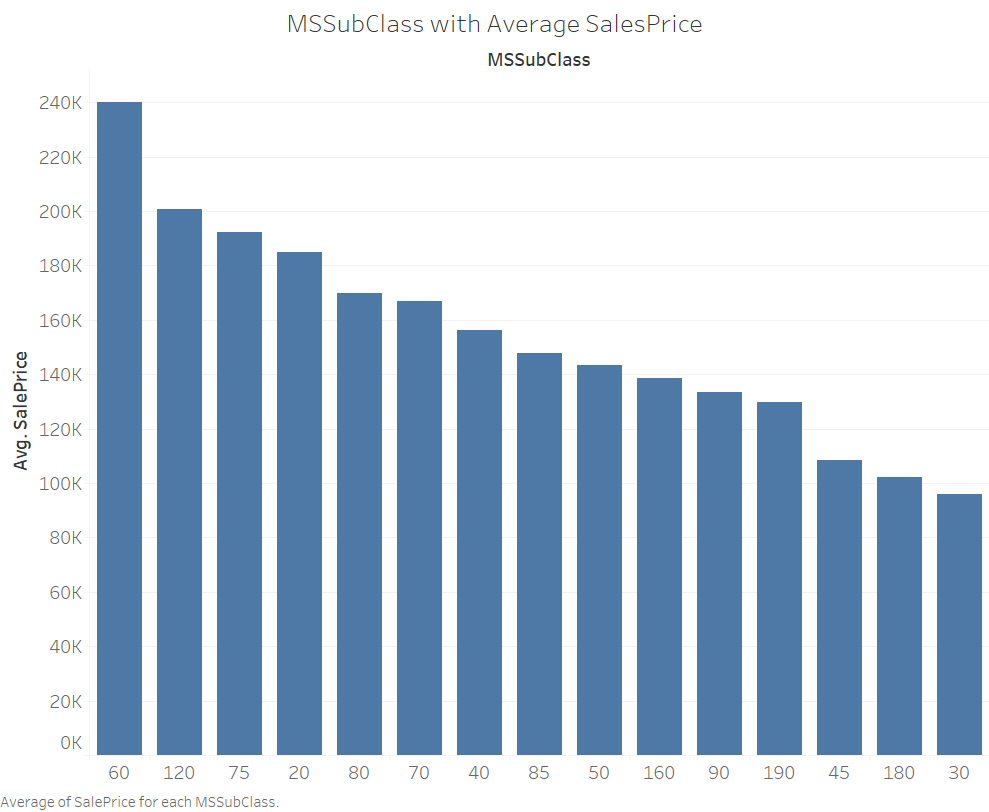

In [79]:
# <<--- MSSubClass --->>

Image(filename='Images\MSSubClass.png') 

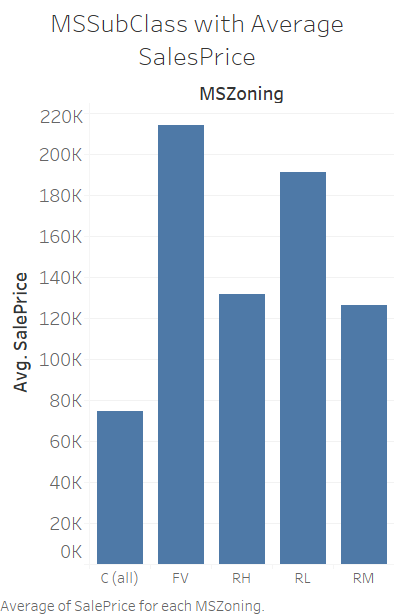

In [80]:
# <<--- MSZoning --->>

Image(filename='Images\MSZoning.png') 

In [81]:
# <<--- Garage --->>

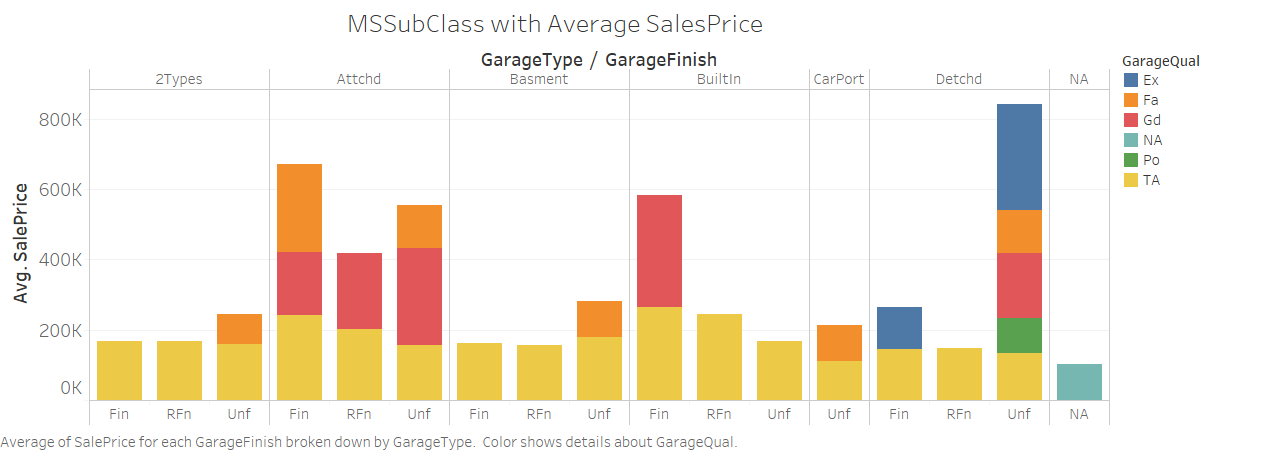

In [82]:
# Garage type, finish, quality with salesprice

Image(filename='Images\Garage_type_finish_quality_with_salesprice.png') 

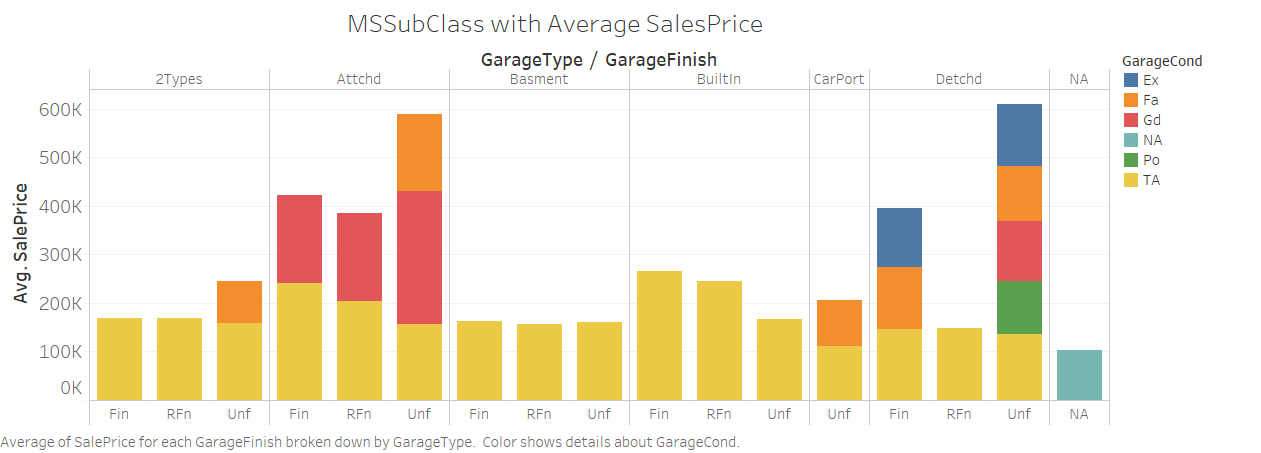

In [83]:
# Garage type, finish, condition with salesprice

Image(filename='Images\Garage_type_finish_condition_with_salesprice.png') 

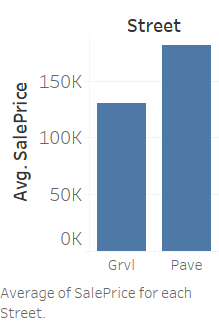

In [84]:
# <<---  Street --->>

Image(filename='Images\Street.png') 

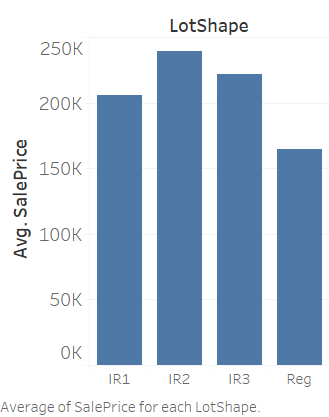

In [85]:
# <<---  LotShape --->>

Image(filename='Images\Lot_Shape.png') 

In [86]:
IR1_SalesPrice = train_df[train_df['LotShape'] == 'IR1']['SalePrice']
IR2_SalesPrice = train_df[train_df['LotShape'] == 'IR2']['SalePrice']
IR3_SalesPrice = train_df[train_df['LotShape'] == 'IR3']['SalePrice']
Reg_SalesPrice = train_df[train_df['LotShape'] == 'Reg']['SalePrice']

In [87]:
data = [(IR1_SalesPrice, IR2_SalesPrice), (IR2_SalesPrice, IR3_SalesPrice), (IR1_SalesPrice, IR3_SalesPrice)]

for first, second in data:
    p_value = ttest_ind(a=first, b=second, equal_var=False)
    print(p_value)

Ttest_indResult(statistic=-2.049756476304295, pvalue=0.04640638919910177)
Ttest_indResult(statistic=0.538554018387045, pvalue=0.5989004633032433)
Ttest_indResult(statistic=-0.5649267955534892, pvalue=0.5870531500036633)


In [88]:
# TRAIN

# Combine 'IR3' and 'IR2' Together

train_df['LotShape'].replace({'IR3': 'IR2'}, inplace=True)

In [89]:
# TEST

# Combine 'IR3' and 'IR2' Together

train_df['LotShape'].replace({'IR3': 'IR2'}, inplace=True)

In [90]:
# Update train.xlsx

train_df.to_excel(excel_writer='train.xlsx', sheet_name='Sheet1')

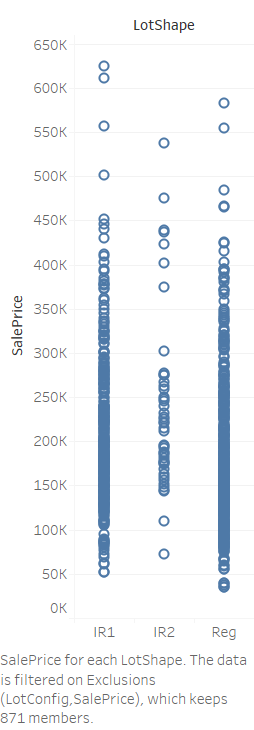

In [91]:
# <<--- LotShape after changes  --->>

Image(filename='Images\Lot_Shape_Modified.png') 

In [92]:
IR1_SalesPrice = train_df[train_df['LotShape'] == 'IR1']['SalePrice']
IR2_SalesPrice = train_df[train_df['LotShape'] == 'IR2']['SalePrice']
Reg_SalesPrice = train_df[train_df['LotShape'] == 'Reg']['SalePrice']

In [93]:
data = [(IR1_SalesPrice, Reg_SalesPrice), (IR2_SalesPrice, Reg_SalesPrice)]

for first, second in data:
    p_value = ttest_ind(a=first, b=second, equal_var=False)
    print(p_value)

Ttest_indResult(statistic=9.136732074812405, pvalue=4.9196667206494e-19)
Ttest_indResult(statistic=5.080878716549496, pvalue=5.477207214589669e-06)


In [94]:
ttest_ind(a=IR1_SalesPrice, b=IR2_SalesPrice, equal_var=False)

Ttest_indResult(statistic=-2.103363471977321, pvalue=0.03995735993593186)

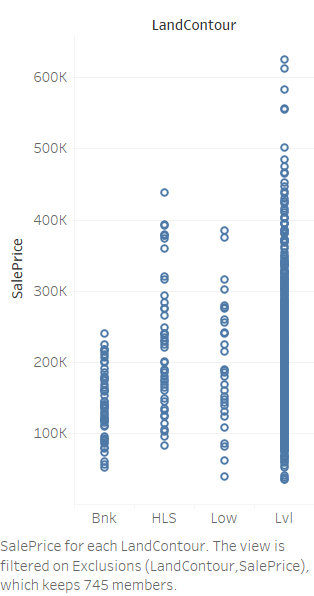

In [95]:
# <<--- LandContour --->>

Image(filename='Images\LandContour.png') 

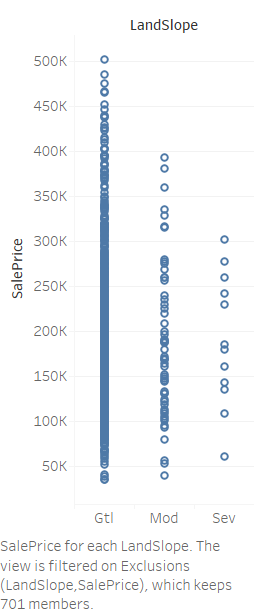

In [96]:
# <<--- LandSlope --->>

Image(filename='Images\LandSlope.png') 

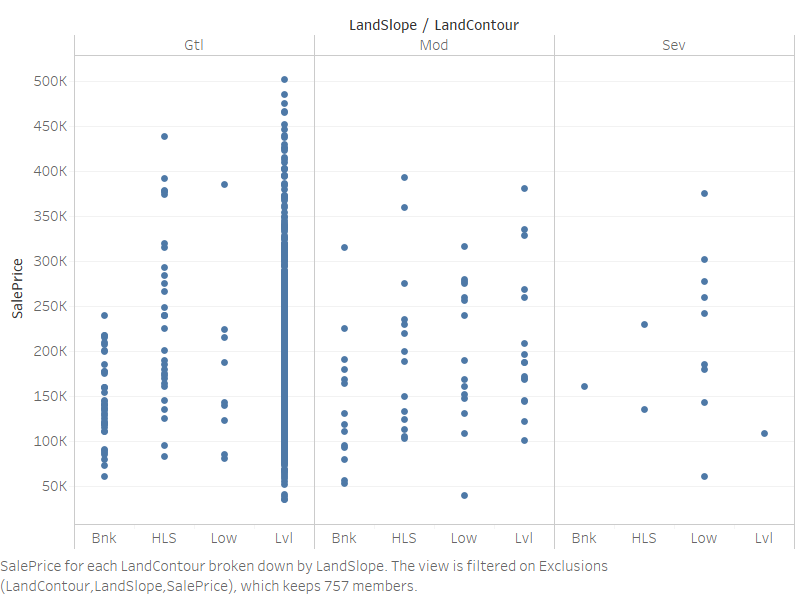

In [97]:
# <<-- Land_Slope_Contour -->>

Image(filename='Images\Land_Slope_Contour.png') 

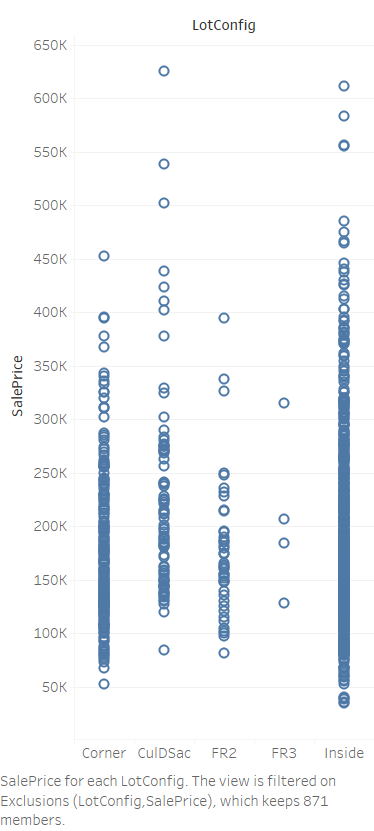

In [98]:
# <<--- LotConfig --->>

Image(filename='Images\LotConfig.png') 

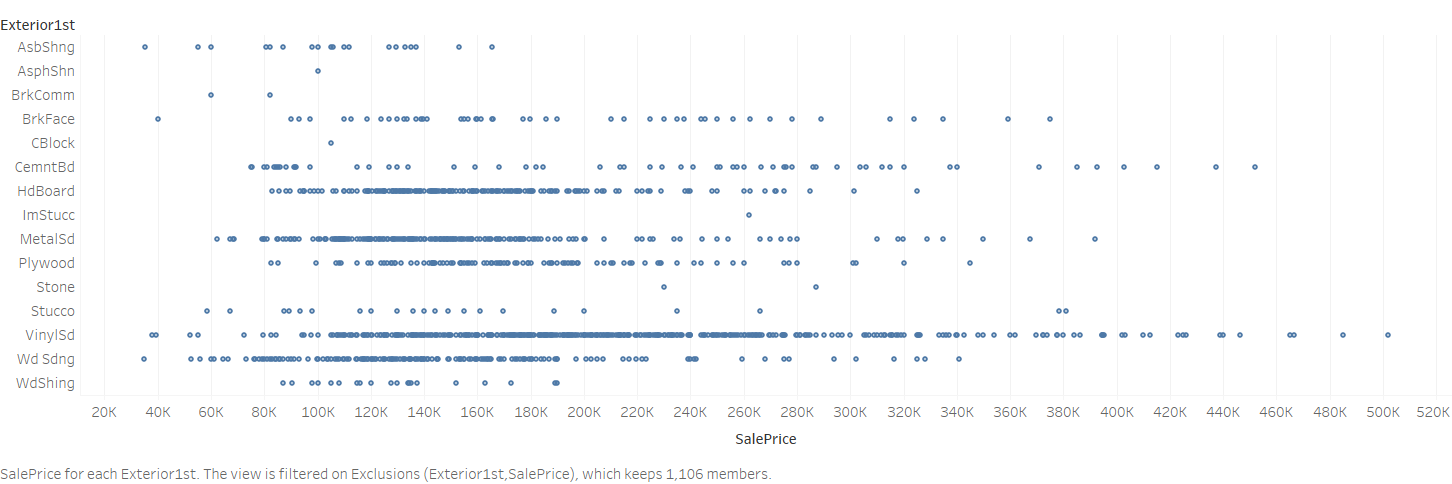

In [99]:
# <<-- Exterior 1st -->>

Image(filename='Images\Exterior1st.png') 

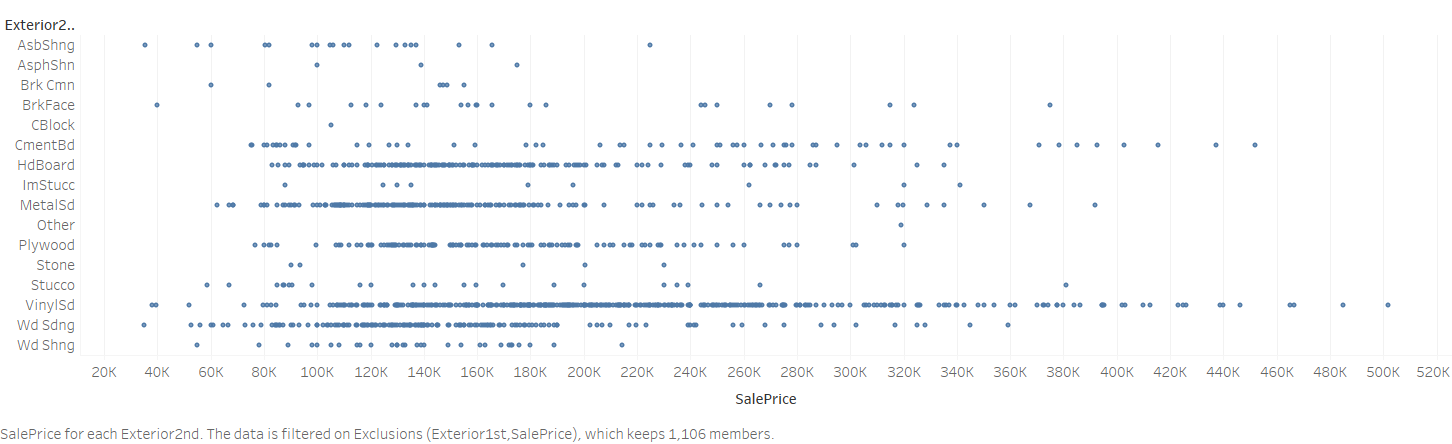

In [100]:
# <<-- Exterior 2nd -->>

Image(filename='Images\Exterior2nd.png') 

In [101]:
# TRAIN

# Drop Exterior1st

train_df.drop(labels='Exterior1st',  axis=1, inplace=True)

In [102]:
# Test 

# Drop Exterior1st

test_df.drop(labels='Exterior1st',  axis=1, inplace=True)

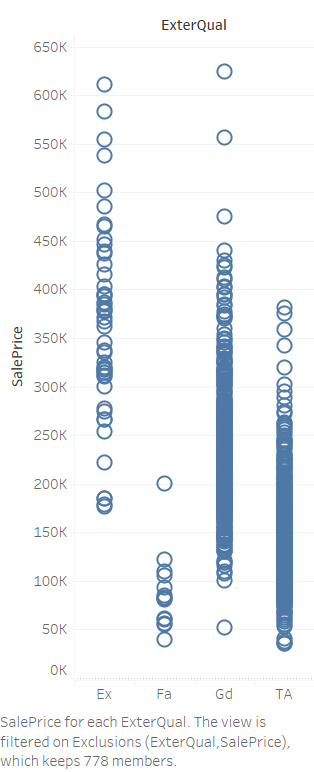

In [103]:
# <<--- ExterQual -->>

Image(filename='Images\ExternalQuality.png') 

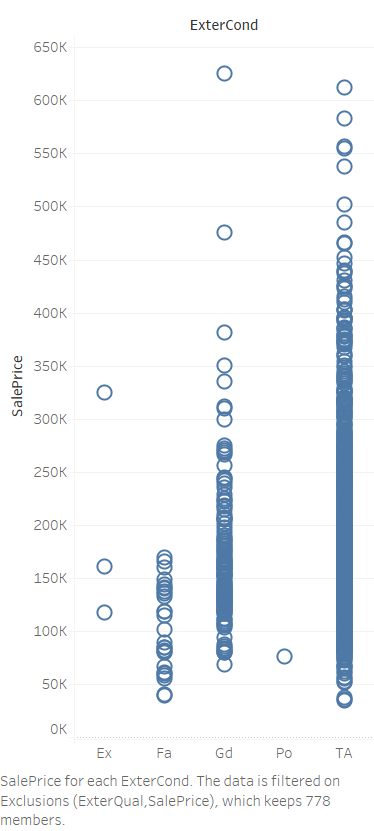

In [104]:
# <<-- ExterCond -->>

Image(filename='Images\ExternalCondition.png') 

In [105]:
# TRAIN

# Drop ExterCond

train_df.drop(labels='ExterCond',  axis=1, inplace=True)

In [106]:
# TEST

# Drop ExterCond

test_df.drop(labels='ExterCond',  axis=1, inplace=True)

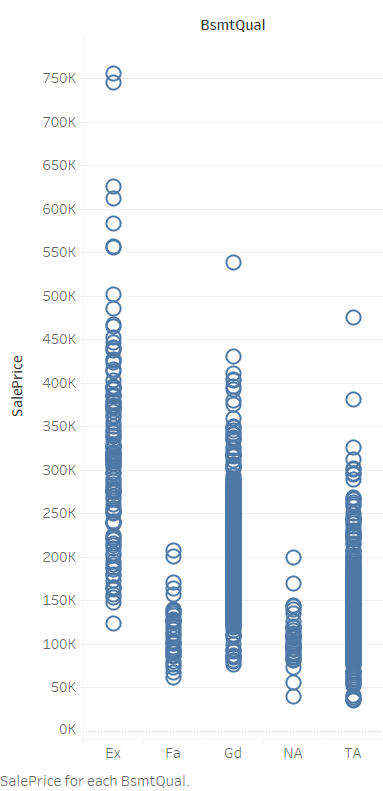

In [107]:
# <<-- BsmtQual -->>

Image(filename='Images\BsmtQual.png') 

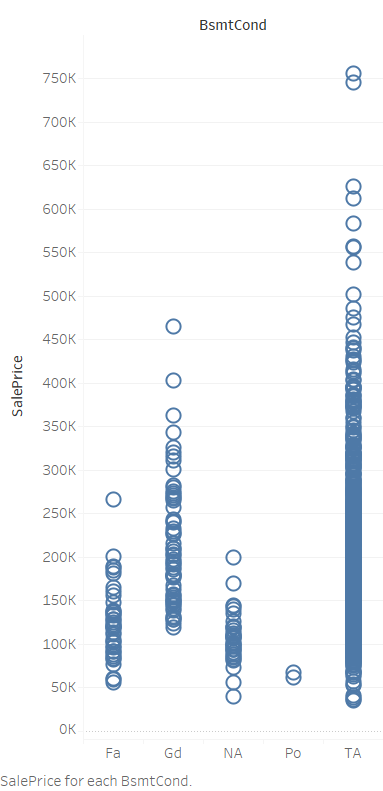

In [108]:
# <<-- BsmtCond -->>

Image(filename='Images\BsmtCond.png')

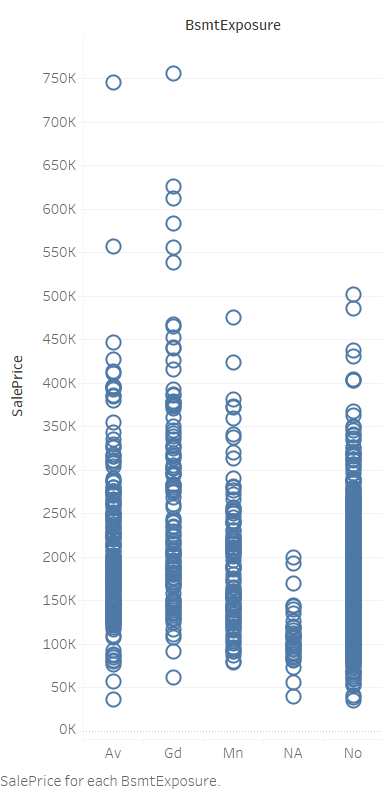

In [109]:
# <<-- BsmtExposure -->>

Image(filename='Images\BsmtExposure.png')

In [110]:
# TRAIN

# Drop 'BsmtFinType2' and 'BsmtCond'

train_df.drop(labels=['BsmtFinType2', 'BsmtCond'], axis=1, inplace=True)

In [111]:
# TEST

# Drop 'BsmtFinType2' and 'BsmtCond'

test_df.drop(labels=['BsmtFinType2', 'BsmtCond'], axis=1, inplace=True)

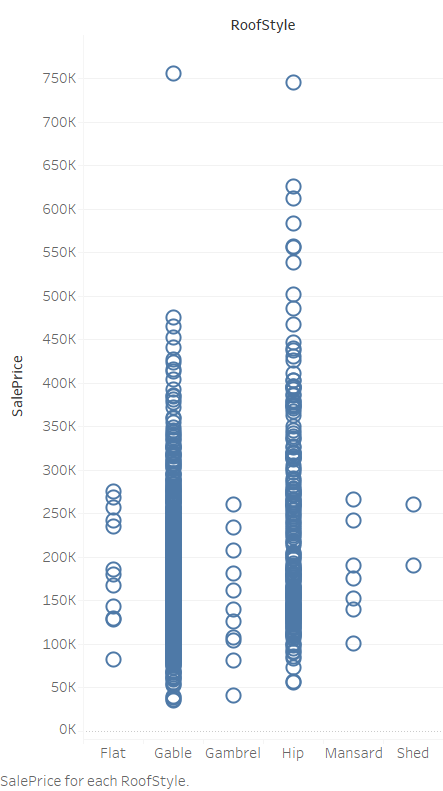

In [112]:
# <<-- RoofStyle -->>

Image(filename='Images\RoofStyle.png')

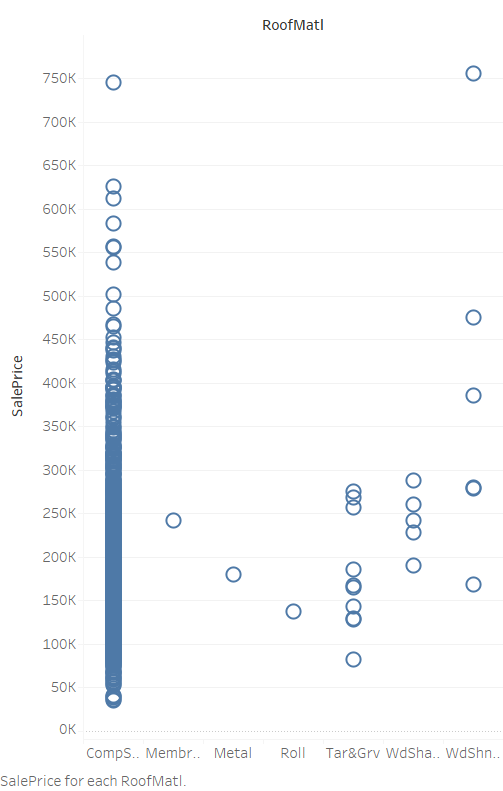

In [113]:
# <<-- RoofMatl -->>

Image(filename='Images\RoofMatl.png')

In [114]:
# TRAIN

# Drop 'RoofMatl'

train_df.drop(labels='RoofMatl',  axis=1, inplace=True)

In [115]:
# TEST

# Drop 'RoofMatl'

test_df.drop(labels='RoofMatl',  axis=1, inplace=True)

In [116]:
train_df['Utilities'].value_counts()

AllPub    1457
NoSeWa       1
Name: Utilities, dtype: int64

In [117]:
train_df['Street'].value_counts()

Pave    1452
Grvl       6
Name: Street, dtype: int64

In [118]:
# TRAIN

# Drop 'Utilities' and 'Street'

train_df.drop(labels=['Utilities', 'Street'],  axis=1, inplace=True)

In [119]:
# TEST

# Drop 'Utilities' and 'Street'

test_df.drop(labels=['Utilities', 'Street'],  axis=1, inplace=True)

In [120]:
# Fix Null of Electrical

for index, data in zip(train_df['Electrical'].index, train_df['Electrical']):
    if str(data) == 'nan':
        
        row = train_df.loc[index, :]
        
        OverallQual = row['OverallQual']
        MSZoning = row['MSZoning']
        
        mask = ((train_df['OverallQual'] == OverallQual) & (train_df['MSZoning'] == MSZoning))
        
        value_counts = train_df[mask]['Electrical'].value_counts()
        
        max_index = value_counts.index[0]
        max_value = value_counts[0]
        
        for index, value in zip(value_counts.index, value_counts):
            if max_value < value:
                max_index = index
                max_value = value
        
        train_df.loc[index, 'Electrical'] = max_index

# Fix Testing Data

In [121]:
test_df.isnull().sum()

MSSubClass          0
MSZoning            4
LotFrontage         2
LotShape            0
LandContour         0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
RoofStyle           0
Exterior2nd         1
MasVnrType          0
MasVnrArea          0
ExterQual           0
Foundation          0
BsmtQual            0
BsmtExposure        0
BsmtFinType1        0
BsmtFinSF1          1
TotalBsmtSF         1
Heating             0
HeatingQC           0
CentralAir          0
Electrical          0
1stFlrSF            0
2ndFlrSF            0
GrLivArea           0
FullBath            0
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         1
TotRmsAbvGrd        0
Functional          2
Fireplaces          0
GarageType          0
GarageFinish        0
GarageCars          0
GarageQual          0
GarageCond          0
PavedDrive          0
WoodDeckSF          0
OpenPorchS

In [122]:
# <<-- Columns to fix -->>

# MSZoning, LotFrontage, Exterior2nd, BsmtFinSF1, TotalBsmtSF, KitchenQual, Functional, SaleType

In [123]:
# <<-- MSZoning -->>

for index, data in zip(test_df['MSZoning'].index, test_df['MSZoning']):
    if str(data) == 'nan':
        
        row = test_df.loc[index, :]
        
        OverallQual = row['OverallQual']
        MSSubClass =  row['MSSubClass']
        
        mask = ((test_df['MSSubClass'] ==  MSSubClass))
        
        test_df.loc[index, 'MSZoning'] = test_df[mask]['MSZoning'].value_counts().idxmax()

In [124]:
# <-- LotFrontage -->

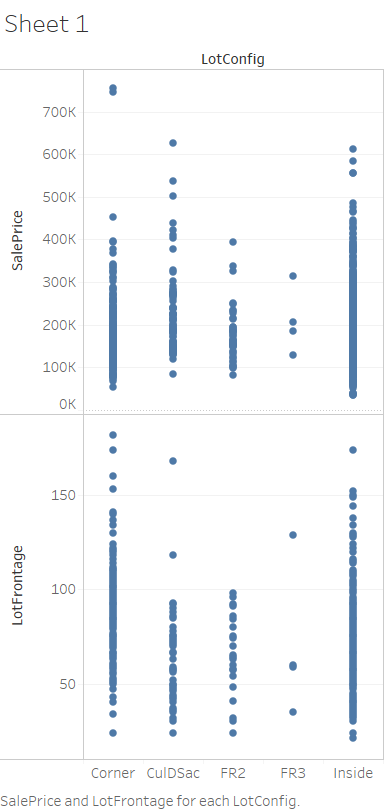

In [125]:
Image(filename='Images\LotFrontage.png')

In [126]:
for index, data in zip(test_df['LotFrontage'].index, test_df['LotFrontage']):
    if str(data) == 'nan':
        
        row = test_df.loc[index, :]
        
        LotConfig = row['LotConfig']
        
        mask = (test_df['LotConfig'] ==  LotConfig)
        
        value = test_df[mask]['LotFrontage'].median()
        
        test_df.loc[index, 'LotFrontage'] = value

In [127]:
# <-- Exterior2nd -->

In [128]:
for index, data in zip(test_df['Exterior2nd'].index, test_df['Exterior2nd']):
    if str(data) == 'nan':
        
        row = test_df.loc[index, :]
        
        ExterQual = row['ExterQual']
        MSZoning = row['MSZoning']
        
        mask = (test_df['LotConfig'] ==  LotConfig) & (test_df['MSZoning'] ==  MSZoning) 
        
        test_df.loc[index, 'Exterior2nd'] = test_df[mask]['Exterior2nd'].value_counts().idxmax()

In [129]:
# <-- 'BsmtFinSF1'  and 'TotalBsmtSF' -->

In [130]:
for column in ['BsmtFinSF1', 'TotalBsmtSF']:
    for index, data in zip(test_df[column].index, test_df[column]):
        if str(data) == 'nan':
            row = test_df.loc[index, :]
            test_df.loc[index, column] = 0

In [131]:
# <-- KitchenQual -->

In [132]:
for index, data in zip(test_df['KitchenQual'].index, test_df['KitchenQual']):
    if str(data) == 'nan':
        
        row = test_df.loc[index, :]
        
        OverallQual = row['OverallQual']
        MSZoning = row['MSZoning']
        
        mask = (test_df['OverallQual'] ==  OverallQual) & (test_df['MSZoning'] ==  MSZoning) 
        
        test_df.loc[index, 'KitchenQual'] = test_df[mask]['KitchenQual'].value_counts().idxmax()

In [133]:
# <-- Functional -->

for index, data in zip(test_df['Functional'].index, test_df['Functional']):
    if str(data) == 'nan':
        
        row = test_df.loc[index, :]
                
        test_df.loc[index, 'Functional'] = test_df['Functional'].value_counts().idxmax()

In [134]:
# <-- SaleType -->

for index, data in zip(test_df['SaleType'].index, test_df['SaleType']):
    if str(data) == 'nan':
        
        row = test_df.loc[index, :]
        
        OverallQual = row['OverallQual']
        MSZoning = row['MSZoning']
        MSSubClass =  row['MSSubClass']
        
        mask = ((test_df['OverallQual'] ==  OverallQual) & (test_df['MSZoning'] ==  MSZoning) & 
                (test_df['MSSubClass'] ==  MSSubClass))
        
        test_df.loc[index, 'SaleType'] = test_df[mask]['SaleType'].value_counts().idxmax()

In [135]:
test_df.isnull().sum()

MSSubClass          0
MSZoning            0
LotFrontage         0
LotShape            0
LandContour         0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
RoofStyle           0
Exterior2nd         0
MasVnrType          0
MasVnrArea          0
ExterQual           0
Foundation          0
BsmtQual            0
BsmtExposure        0
BsmtFinType1        0
BsmtFinSF1          0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          0
1stFlrSF            0
2ndFlrSF            0
GrLivArea           0
FullBath            0
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
GarageType          0
GarageFinish        0
GarageCars          0
GarageQual          0
GarageCond          0
PavedDrive          0
WoodDeckSF          0
OpenPorchS

In [136]:
train_df.shape

(1459, 51)

In [137]:
test_df.shape

(1459, 50)

## Encode Categorical variable

In [138]:
continuous_features = list()
categorical_features = list()

for feature in test_df.columns:
    if feature in discrete_features:
        categorical_features.append(feature)
    else:
        continuous_features.append(feature)

continuous_features.append('SalePrice')

In [139]:
train_df.drop('FuseF', axis=0, inplace=True)

In [140]:
train_df.shape

(1458, 51)

In [141]:
test_df.shape

(1459, 50)

In [142]:
# Merge Data Frames

merged_df = pd.concat(objs=[train_df, test_df],
    axis=0,
    join='outer')

In [143]:
merged_df['GarageCars'].replace({'NA':0}, inplace=True)

In [144]:
# Features to Scale

cols = [column for column in continuous_features if column != 'SalePrice']

In [145]:
test_df['GarageCars'].unique()

array([1.0, 2.0, 3.0, 0.0, 4.0, 5.0, 'NA'], dtype=object)

In [146]:
ss = StandardScaler()

merged_df[cols] = ss.fit_transform(merged_df[cols])

In [147]:
new_df = pd.get_dummies(data=merged_df, drop_first=True)

In [148]:
train_df = new_df.iloc[:1458, :]

In [149]:
train_df.shape

(1458, 188)

In [150]:
test_df = new_df.iloc[1458:, :]

In [151]:
test_df.shape

(1459, 188)

In [152]:
# Train Set

# <<-- Dependent and Independent Variables -->>

columns_to_select = [column for column in train_df.columns if column != 'SalePrice']
X = train_df[columns_to_select]
Y = train_df['SalePrice']

In [153]:
# Test Set

test_df = test_df[columns_to_select]

In [154]:
X.shape

(1458, 187)

In [155]:
test_df.shape

(1459, 187)

# Model Making

## 1. Multiple Linear Regression

## 2. Ridge 

In [156]:
ridge = Ridge()
ridge.fit(X, Y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [157]:
# <<--- K fold cross validation --->> Before Parameter Tuning
accuracies = cross_val_score(estimator = ridge, scoring='r2', X = X, y = Y, cv = 10) 

print("Average R Square: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Average R Square: 86.74 %
Standard Deviation: 4.68 %


In [158]:
parameters = {
    'alpha' : [1, 2, 3, 4, 5, 6, 7, 8, 9],
'normalize' : [True,False],
'solver': ['auto', 'svd', 'lsqr']
}

In [159]:
# <<-- Check the best Ridge Regression Model by parameter tuning -->>

random_search = RandomizedSearchCV(estimator = ridge,
                           param_distributions  = parameters,
                           scoring = 'r2', 
                           cv = 10,
                           n_jobs=1)

random_search = random_search.fit(X, Y)

best_accuracy = random_search.best_score_   
best_parameters = random_search.best_params_  

print("Best R square: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best R square: 87.49 %
Best Parameters: {'solver': 'auto', 'normalize': False, 'alpha': 7}


In [161]:
final_ridge_regressor = Ridge(solver='auto', normalize=False, alpha=7)

In [162]:
# <<--- K fold cross validation --->> After Parameter Tuning
accuracies = cross_val_score(estimator = final_ridge_regressor, scoring='r2', X = X, y = Y, cv = 10) 

print("Average R Square: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Average R Square: 87.49 %
Standard Deviation: 4.79 %


## 3. Lasso Regression

In [163]:
lasso = Lasso()
lasso.fit(X, Y)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [164]:
# <<--- K fold cross validation --->> Before Parameter Tuning

accuracies = cross_val_score(estimator = lasso, scoring='r2', X = X, y = Y, cv = 10) 

print("Average R Square: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Average R Square: 85.05 %
Standard Deviation: 6.65 %


In [165]:
parameters = {
    'alpha' : [1, 2, 3, 4, 5, 6, 7, 8, 9],
'normalize' : [True,False]
}

In [166]:
# <<-- Check the best Lasso Regression Model by parameter tuning -->>

random_search = RandomizedSearchCV(estimator = lasso,
                           param_distributions  = parameters,
                           scoring = 'r2', 
                           cv = 10,
                           n_jobs=1)

random_search = random_search.fit(X, Y)

best_accuracy = random_search.best_score_   
best_parameters = random_search.best_params_  

print("Best R square: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best R square: 86.22 %
Best Parameters: {'normalize': True, 'alpha': 9}


In [167]:
final_lasso_regressor = Lasso(normalize=True, alpha=9)

In [168]:
# <<--- K fold cross validation --->> After Parameter Tuning
accuracies = cross_val_score(estimator = final_lasso_regressor, scoring='r2', X = X, y = Y, cv = 10) 

print("Average R Square: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Average R Square: 86.22 %
Standard Deviation: 5.82 %


## 4. SVR (Suppor Vector Regression)

In [169]:
svr = SVR()
svr.fit(X, Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [170]:
# <<--- K fold cross validation --->> Before Parameter Tuning

accuracies = cross_val_score(estimator = svr, scoring='r2', X = X, y = Y, cv = 10) 

print("Average R Square: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Average R Square: -5.29 %
Standard Deviation: 3.08 %


In [171]:
parameters = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [3, 2, 1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  

In [172]:
# <<-- Check the best SVR Model by parameter tuning -->>

random_search = RandomizedSearchCV(estimator = svr,
                           param_distributions  = parameters,
                           scoring = 'r2', 
                           cv = 10,
                           n_jobs=1)

random_search = random_search.fit(X, Y)

best_accuracy = random_search.best_score_   
best_parameters = random_search.best_params_  

print("Best R square: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best R square: -1.77 %
Best Parameters: {'kernel': 'rbf', 'gamma': 0.001, 'C': 100}


In [174]:
final_svr_regressor = SVR(kernel= 'rbf', gamma= 0.001, C= 100)

In [175]:
# <<--- K fold cross validation --->> After Parameter Tuning
accuracies = cross_val_score(estimator = final_svr_regressor, scoring='r2', X = X, y = Y, cv = 10) 

print("Average R Square: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Average R Square: -1.77 %
Standard Deviation: 3.17 %


## 5. Decision Trees

In [176]:
random_forest = RandomForestRegressor()
random_forest.fit(X, Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [177]:
# <<--- K fold cross validation --->> Before Parameter Tuning

accuracies = cross_val_score(estimator = random_forest, scoring='r2', X = X, y = Y, cv = 10) 

print("Average R Square: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Average R Square: 84.63 %
Standard Deviation: 3.83 %


In [178]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 3000, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [179]:
# Create the Random grid

parameters = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [180]:
# <<-- Check the best Decision Tree Model by parameter tuning -->>

random_search = RandomizedSearchCV(estimator = random_forest,
                           param_distributions  = parameters,
                           scoring = 'r2', 
                           cv = 10,
                           n_jobs=4)

random_search = random_search.fit(X, Y)

best_accuracy = random_search.best_score_   
best_parameters = random_search.best_params_  

print("Best R square: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best R square: 86.74 %
Best Parameters: {'n_estimators': 1925, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': False}


In [181]:
final_random_forest_regressor = RandomForestRegressor(n_estimators= 1925, min_samples_split= 10, min_samples_leaf= 1, 
                                                      max_features= 'sqrt', max_depth= 70, bootstrap= False)

In [182]:
# <<--- K fold cross validation --->> After Parameter Tuning

accuracies = cross_val_score(estimator = final_random_forest_regressor, scoring='r2', X = X, y = Y, cv = 10) 

print("Average R Square: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Average R Square: 86.75 %
Standard Deviation: 3.69 %


## 6. Gradient Boost

In [183]:
gradient_boost = GradientBoostingRegressor()
gradient_boost.fit(X, Y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [184]:
# <<--- K fold cross validation --->> Before Parameter Tuning

accuracies = cross_val_score(estimator = gradient_boost, scoring='r2', X = X, y = Y, cv = 10) 

print("Average R Square: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Average R Square: 87.53 %
Standard Deviation: 7.33 %


In [187]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 3000, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

In [189]:
parameters = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [190]:
# <<-- Check the best Gradient Boost Model by parameter tuning -->>

random_search = RandomizedSearchCV(estimator = gradient_boost,
                           param_distributions  = parameters,
                           scoring = 'r2', 
                           cv = 10,
                           n_jobs=4)

random_search = random_search.fit(X, Y)

best_accuracy = random_search.best_score_   
best_parameters = random_search.best_params_  

print("Best R square: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best R square: 87.66 %
Best Parameters: {'n_estimators': 765, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 40}


In [191]:
final_gradient_boost_regressor = GradientBoostingRegressor(n_estimators= 765, min_samples_split= 5, min_samples_leaf= 4, max_features= 'sqrt', max_depth= 40)

In [192]:
# <<--- K fold cross validation --->> After Parameter Tuning

accuracies = cross_val_score(estimator = final_gradient_boost_regressor, scoring='r2', X = X, y = Y, cv = 10) 

print("Average R Square: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Average R Square: 87.09 %
Standard Deviation: 6.98 %


## 7. XGBoost 

In [193]:
xgboost = XGBRegressor()
xgboost.fit(X, Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [194]:
# <<--- K fold cross validation --->> Before Parameter Tuning

accuracies = cross_val_score(estimator = xgboost, scoring='r2', X = X, y = Y, cv = 10) 

print("Average R Square: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Average R Square: 86.12 %
Standard Deviation: 8.06 %


In [195]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 100)]
max_depth = range(3, 20, 2)
gamma = [0, 1, 2, 3, 4, 5]
colsample_bytree = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
subsample = [0.8, 0.85, 0.9, 0.95, 1]

In [196]:
# Create the Random grid

parameters = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'gamma': gamma,
               'colsample_bytree': colsample_bytree,
               'subsample': subsample}

In [197]:
# <<-- Check the best XGBoost Tree Model by parameter tuning -->>

random_search = RandomizedSearchCV(estimator = xgboost,
                           param_distributions  = parameters,
                           scoring = 'r2', 
                           cv = 10,
                           n_jobs=4)

random_search = random_search.fit(X, Y)

best_accuracy = random_search.best_score_   
best_parameters = random_search.best_params_  

print("Best R square: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best R square: 87.49 %
Best Parameters: {'subsample': 0.95, 'n_estimators': 290, 'max_depth': 3, 'gamma': 4, 'colsample_bytree': 0.8}


In [198]:
final_xgboost_regressor = XGBRegressor(subsample= 0.95, n_estimators= 290, max_depth= 3, gamma= 4, 
                                       colsample_bytree= 0.8)

In [199]:
# <<--- K fold cross validation --->> After Parameter Tuning

accuracies = cross_val_score(estimator = final_xgboost_regressor, scoring='r2', X = X, y = Y, cv = 10) 

print("Average R Square: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Average R Square: 87.49 %
Standard Deviation: 6.15 %


## 9. Ada Boost 

In [200]:
adaboost = AdaBoostRegressor()
adaboost.fit(X, Y)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None)

In [201]:
# <<--- K fold cross validation --->> Before Parameter Tuning

accuracies = cross_val_score(estimator = adaboost, scoring='r2', X = X, y = Y, cv = 10) 

print("Average R Square: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Average R Square: 80.50 %
Standard Deviation: 4.49 %


# Save Models

In [202]:
with open('Ridge Regression.txt','wb') as f:
    pickle.dump(final_ridge_regressor, f)

In [203]:
with open('Lasso Regression.txt','wb') as f:
    pickle.dump(final_lasso_regressor, f)

In [204]:
with open('Random Forest Regression.txt','wb') as f:
    pickle.dump(final_random_forest_regressor, f)

In [205]:
with open('XGBoost Regression.txt','wb') as f:
    pickle.dump(final_xgboost_regressor, f)

In [206]:
with open('Gradient Boost Regression.txt','wb') as f:
    pickle.dump(final_gradient_boost_regressor, f)

In [207]:
with open('Ada Boost Regression.txt','wb') as f:
    pickle.dump(adaboost, f)

In [208]:
with open('SVR Regression.txt','wb') as f:
    pickle.dump(final_svr_regressor, f)

# Predict Test Set

In [210]:
final_ridge_regressor.fit(X, Y)
final_lasso_regressor.fit(X, Y)
final_random_forest_regressor.fit(X, Y)
final_xgboost_regressor.fit(X, Y)
final_svr_regressor.fit(X, Y)
final_gradient_boost_regressor.fit(X, Y)
adaboost.fit(X, Y)

ridge_predictions = final_ridge_regressor.predict(test_df)
lasso_predictions = final_lasso_regressor.predict(test_df)
random_forest_predictions = final_random_forest_regressor.predict(test_df)
xgboost_predictions = final_xgboost_regressor.predict(test_df)
svr_predictions = final_svr_regressor.predict(test_df)
gradient_boost_predictions = final_gradient_boost_regressor.predict(test_df)
adaboost_predictions = adaboost.predict(test_df)

# Save CSV Files

In [211]:
test_id = pd.read_csv('test.csv')['Id']

In [212]:
# <<<---- Save adaboost predictions ---->>>

adaboost_df = pd.DataFrame(data=list(zip(test_id, adaboost_predictions)), columns=['Id', 'SalePrice'])
adaboost_df.to_csv('adaboost_predictions.csv')

In [213]:
# <<<---- Save Gradient Boost predictions ---->>>

gradient_boost_df = pd.DataFrame(data=list(zip(test_id, gradient_boost_predictions)), columns=['Id', 'SalePrice'])
gradient_boost_df.to_csv('gradient_boost_predictions.csv')

In [214]:
# <<<---- Save SVR predictions ---->>>

svr_df = pd.DataFrame(data=list(zip(test_id, svr_predictions)), columns=['Id', 'SalePrice'])
svr_df.to_csv('svr_predictions.csv')

In [215]:
# <<<---- Save ridge predictions ---->>>

ridge_df = pd.DataFrame(data=list(zip(test_id, ridge_predictions)), columns=['Id', 'SalePrice'])
ridge_df.to_csv('ridge_predictions.csv')

In [216]:
# <<<---- Save lasso predictions ---->>>

ridge_df = pd.DataFrame(data=list(zip(test_id, lasso_predictions)), columns=['Id', 'SalePrice'])
ridge_df.to_csv('lasso_predictions.csv')

In [217]:
# <<<---- Save radomforest predictions ---->>>

random_forest_df = pd.DataFrame(data=list(zip(test_id, random_forest_predictions)), columns=['Id', 'SalePrice'])
random_forest_df.to_csv('random_forest_predictions.csv')

In [218]:
# <<<---- Save xgboost predictions ---->>>

xgboost_df = pd.DataFrame(data=list(zip(test_id, xgboost_predictions)), columns=['Id', 'SalePrice'])
xgboost_df.to_csv('xgboost_predictions.csv')